In [1]:
# Bending rigidity

# Random
import numpy as np 
from scipy.integrate import solve_bvp 
from FunctionDefinitions.endoInit import endoInit
from math import sin, cos, tan, pi, tanh, ceil
import pandas as pd
from scipy import interpolate
from random import sample
import itertools

# xGBoost
import xgboost as xgb

# Neural Net
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
import h5py
from keras.models import load_model


# Metrics
import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix


# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 16}


True

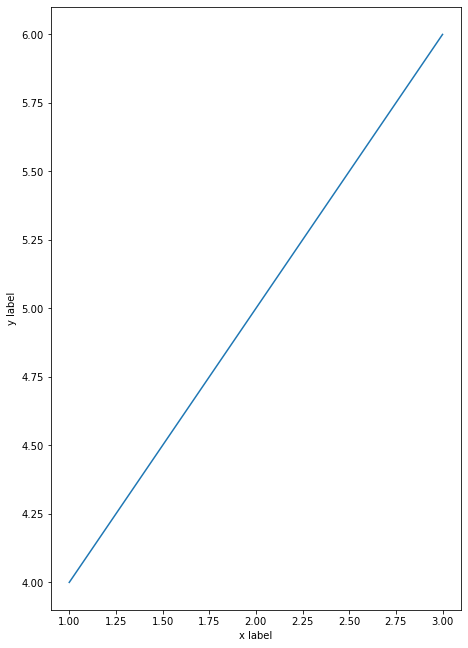

In [2]:
# https://kavigupta.org/2019/05/18/Setting-the-size-of-figures-in-matplotlib/

from matplotlib.image import imread
from tempfile import NamedTemporaryFile

def get_size(fig, dpi=100):
    with NamedTemporaryFile(suffix='.png') as f:
        fig.savefig(f.name, bbox_inches='tight', dpi=dpi)
        height, width, _channels = imread(f.name).shape
        return width / dpi, height / dpi

def set_size(fig, size, dpi=100, eps=1e-2, give_up=2, min_size_px=10):
    target_width, target_height = size
    set_width, set_height = target_width, target_height # reasonable starting point
    deltas = [] # how far we have
    while True:
        fig.set_size_inches([set_width, set_height])
        actual_width, actual_height = get_size(fig, dpi=dpi)
        set_width *= target_width / actual_width
        set_height *= target_height / actual_height
        deltas.append(abs(actual_width - target_width) + abs(actual_height - target_height))
        if deltas[-1] < eps:
            return True
        if len(deltas) > give_up and sorted(deltas[-give_up:]) == deltas[-give_up:]:
            return False
        if set_width * dpi < min_size_px or set_height * dpi < min_size_px:
            return False

        
        
fig = plt.figure()
fig.gca().plot([1, 2, 3], [4, 5, 6])
plt.gca().set_xlabel("x label")
plt.gca().set_ylabel("y label")
set_size(fig, (8.5 - 2, 11 - 2)) # Size chosen for 1 inch page margins
#plt.savefig("update-size.png", bbox_inches='tight')
#print(imread("update-size.png").shape)


In [3]:
# Basic imports
train = pd.read_csv('train.csv')
train.loc[train.omega == -1, 'omega'] = 0

validation = pd.read_csv('validation.csv')
validation.loc[validation.omega == -1, 'omega'] = 0

test = pd.read_csv('test.csv')
test.loc[test.omega == -1, 'omega'] = 0


# Normalizing
# Normalizing needs to be done based on train to maintain that validation and test are unseen datasets 

train['C0_norm'] = (train.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))
test['C0_norm'] = (test.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))
validation['C0_norm'] = (validation.C0*-1 - min(train.C0*-1))/(max(train.C0*-1) - min(train.C0*-1))

train['lam_norm'] = (train.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))
test['lam_norm'] = (test.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))
validation['lam_norm'] = (validation.lam_dim - min(train.lam_dim))/(max(train.lam_dim) - min(train.lam_dim))

train['rad_norm'] = (train.rad - min(train.rad))/(max(train.rad) - min(train.rad))
test['rad_norm'] = (test.rad - min(train.rad))/(max(train.rad) - min(train.rad))
validation['rad_norm'] = (validation.rad - min(train.rad))/(max(train.rad) - min(train.rad))

train['delta_norm'] = (train.delta - min(train.delta))/(max(train.delta) - min(train.delta))
test['delta_norm'] = (test.delta - min(train.delta))/(max(train.delta) - min(train.delta))
validation['delta_norm'] = (validation.delta - min(train.delta))/(max(train.delta) - min(train.delta))

In [4]:
# xGBoost

# Establish validation and train datasets

features = ['C0_norm', 'rad_norm','lam_norm', 'delta_norm']

x_train = train[features].to_numpy()
y_train = train.omega.to_numpy()

#x_validation = validation[['C0', 'rad','lam_dim', 'pressure_dim']].to_numpy()
x_validation = validation[features].to_numpy()
y_validation = validation.omega.to_numpy()

x_test = test[features].to_numpy()
y_test = test.omega.to_numpy()

# Calculate ratio of omegas to non omegas for both train and validation csvs

len_train_omegas = len(train.where(train.omega == 1).dropna(how = 'all').reset_index(drop = 'True'))
len_train_not_omegas = len(train.where(train.omega != 1).dropna(how = 'all').reset_index(drop = 'True'))

len_val_omegas = len(validation.where(validation.omega == 1).dropna(how = 'all').reset_index(drop = 'True'))
len_val_not_omegas = len(validation.where(validation.omega != 1).dropna(how = 'all').reset_index(drop = 'True'))


print('Ratio for train set: ', len_train_omegas/len_train_not_omegas, ' Total omegas: ', len_train_omegas)
print('Ratio for validation set: ', len_val_omegas/len_val_not_omegas, ' Total omegas: ', len_val_omegas)


param = { 'objective': 'binary:logistic', #'reg:squarederror',
              'learning_rate': .01,
              'max_depth': 100,
              'min_child_weight': 10,
              'gamma': 1,
              'subsample': .2,
              'colsample_bytree': .9,
              'seed': 23,
              'n_estimators':700}

spw = len_train_not_omegas/len_train_omegas
xg_reg = xgb.XGBClassifier(**param,scale_pos_weight=spw, use_label_encoder = False) # change the value of scale_pos_weight to reweight the importance of false/true negatives
xg_reg.fit(x_train, y_train) 

y_pred = xg_reg.predict(x_validation)
RF_predictions = [round(value) for value in y_pred]


Ratio for train set:  0.024748688811188812  Total omegas:  453
Ratio for validation set:  0.03771805752003772  Total omegas:  80
[09:53:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [5]:
# The best Neural net model was genereated in NN_classification_P and saved as best_model
NN = load_model('best_model.h5')
NN.summary()

NN_predictions = NN.predict(x_validation)
rounded = [round(x[0]) for x in NN_predictions]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                50        
_________________________________________________________________
dense_1 (Dense)              (None, 100)               1100      
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 12,271
Trainable params: 12,271
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Create the grid of parameters overwhich to define a phase diagram using the ML model 
R0 = 20
loop_number = 30
C0_ran = np.linspace(0, .07, loop_number)*R0*(-1) # We need to non-dimensionalize consistently since I recorded non-dimensionalized C0 instead of dimensional 
grid_params_pre = pd.read_csv('Test_parameter_combos_delta.csv')

grid_params = []
for i in grid_params_pre.index:
    for j in C0_ran: 
        grid_params.append([j, grid_params_pre.rad.iloc[i], grid_params_pre.lam_dim.iloc[i], grid_params_pre.delta.iloc[i]])

grid_params = pd.DataFrame(grid_params, columns=['C0', 'rad', 'lam_dim', 'delta'])

# Code to normalize features between 0 and 1
grid_params['C0_norm'] = (grid_params.C0*-1 - min(grid_params.C0*-1))/(max(grid_params.C0*-1) - min(grid_params.C0*-1))
grid_params['lam_norm'] = (grid_params.lam_dim - min(grid_params.lam_dim))/(max(grid_params.lam_dim) - min(grid_params.lam_dim))
grid_params['rad_norm'] = (grid_params.rad - min(grid_params.rad))/(max(grid_params.rad) - min(grid_params.rad))
grid_params['delta_norm'] = (grid_params.delta - min(grid_params.delta))/(max(grid_params.delta) - min(grid_params.delta))
grid_params.head()


,C0,rad,lam_dim,delta,C0_norm,lam_norm,rad_norm,delta_norm
0,-0.000000,25.0,0.003,0.125,0.000000,0.0,0.0,0.0
1,-0.048276,25.0,0.003,0.125,0.034483,0.0,0.0,0.0
2,-0.096552,25.0,0.003,0.125,0.068966,0.0,0.0,0.0
3,-0.144828,25.0,0.003,0.125,0.103448,0.0,0.0,0.0
4,-0.193103,25.0,0.003,0.125,0.137931,0.0,0.0,0.0


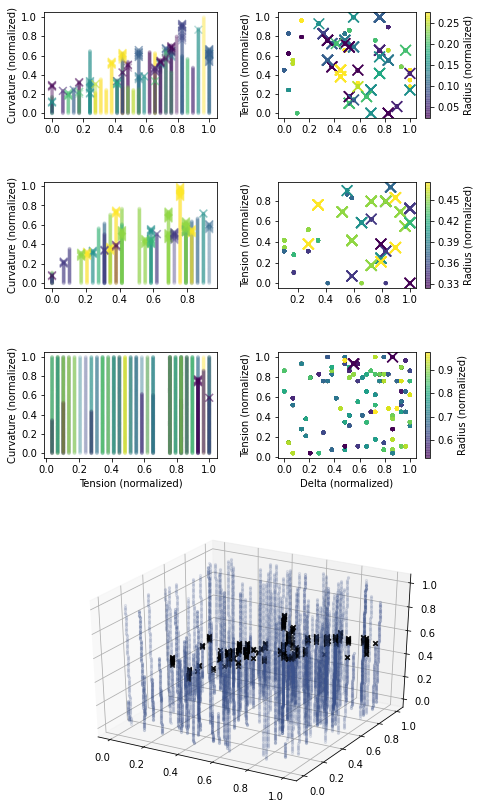

In [12]:
fig = plt.figure(figsize=(8.5, 11))
gs = GridSpec(nrows=5, ncols=2, width_ratios = [1,1])



# All training data; covers first 6 rows and first 2 columns
rad_sections = [[0, .3], [.3, .5], [.5, 1]]
names = ['0003', '0305', '0510']

ax0 = fig.add_subplot(gs[0, 0])
i = 0
section = rad_sections[i]
train_sub = train.where(train.rad_norm > section[0])
train_sub = train_sub.where(train_sub.rad_norm < section[1])
    
Curv_ten_rad = ax0.scatter(train_sub.lam_norm, train_sub.C0_norm, c = train_sub.rad_norm, marker = '.', alpha = .1)
omegas = train_sub.where(train_sub.omega == 1).dropna(how = 'all')
ax0.scatter(omegas.lam_norm, 1*omegas.C0_norm, c = omegas.rad_norm, marker = 'x', s = 60, alpha = .3) # was black
#cbar = plt.colorbar(Curv_ten_rad)
tick_locator = matplotlib.ticker.MaxNLocator(nbins=5)
#cbar.locator = tick_locator
#cbar.update_ticks()
#cbar.set_label('Radius (normalized)')
if i == 2:
    ax0.set_xlabel('Tension (normalized)')
ax0.set_ylabel('Curvature (normalized)')
ax0.locator_params(axis="x", nbins=6)
ax0.locator_params(axis="y", nbins=6)

ax1 = fig.add_subplot(gs[0, 1])
Curv_ten_rad = ax1.scatter(train_sub.delta_norm, train_sub.lam_norm, c = train_sub.rad_norm, marker = '.', alpha = .3)
omegas = train_sub.where(train_sub.omega == 1).dropna(how = 'all')
Curv_ten_rad_omega = ax1.scatter(omegas.delta_norm, 1*omegas.lam_norm, c = omegas.rad_norm, marker = 'x', s = 20*(4**1.25), alpha = 1)
cbar = plt.colorbar(Curv_ten_rad)
tick_locator = matplotlib.ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('Radius (normalized)')
if i == 2:
    ax1.set_xlabel('Delta (normalized)')
ax1.set_ylabel('Tension (normalized)')
ax1.locator_params(axis="x", nbins=6)
ax1.locator_params(axis="y", nbins=6)

ax3 = fig.add_subplot(gs[1, 0])
i = 1
section = rad_sections[i]
train_sub = train.where(train.rad_norm > section[0])
train_sub = train_sub.where(train_sub.rad_norm < section[1])
    
Curv_ten_rad = ax3.scatter(train_sub.lam_norm, train_sub.C0_norm, c = train_sub.rad_norm, marker = '.', alpha = .1)
omegas = train_sub.where(train_sub.omega == 1).dropna(how = 'all')
ax3.scatter(omegas.lam_norm, 1*omegas.C0_norm, c = omegas.rad_norm, marker = 'x', s = 60, alpha = .3) # was black
#cbar = plt.colorbar(Curv_ten_rad)
tick_locator = matplotlib.ticker.MaxNLocator(nbins=5)
#cbar.locator = tick_locator
#cbar.update_ticks()
#cbar.set_label('Radius (normalized)')
if i == 2:
    ax3.set_xlabel('Tension (normalized)')
ax3.set_ylabel('Curvature (normalized)')
ax3.locator_params(axis="x", nbins=6)
ax3.locator_params(axis="y", nbins=6)

ax4 = fig.add_subplot(gs[1, 1])
Curv_ten_rad = ax4.scatter(train_sub.delta_norm, train_sub.lam_norm, c = train_sub.rad_norm, marker = '.', alpha = .3)
omegas = train_sub.where(train_sub.omega == 1).dropna(how = 'all')
Curv_ten_rad_omega = ax4.scatter(omegas.delta_norm, 1*omegas.lam_norm, c = omegas.rad_norm, marker = 'x', s = 20*(4**1.25), alpha = 1)
cbar = plt.colorbar(Curv_ten_rad)
tick_locator = matplotlib.ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('Radius (normalized)')
if i == 2:
    ax4.set_xlabel('Delta (normalized)')
ax4.set_ylabel('Tension (normalized)')
ax4.locator_params(axis="x", nbins=6)
ax4.locator_params(axis="y", nbins=6)

ax5 = fig.add_subplot(gs[2, 0])
i = 2
section = rad_sections[i]
train_sub = train.where(train.rad_norm > section[0])
train_sub = train_sub.where(train_sub.rad_norm < section[1])
    
Curv_ten_rad = ax5.scatter(train_sub.lam_norm, train_sub.C0_norm, c = train_sub.rad_norm, marker = '.', alpha = .1)
omegas = train_sub.where(train_sub.omega == 1).dropna(how = 'all')
ax5.scatter(omegas.lam_norm, 1*omegas.C0_norm, c = omegas.rad_norm, marker = 'x', s = 60, alpha = .3) # was black
#cbar = plt.colorbar(Curv_ten_rad)
tick_locator = matplotlib.ticker.MaxNLocator(nbins=5)
#cbar.locator = tick_locator
#cbar.update_ticks()
#cbar.set_label('Radius (normalized)')
if i == 2:
    ax5.set_xlabel('Tension (normalized)')
ax5.set_ylabel('Curvature (normalized)')
ax5.locator_params(axis="x", nbins=6)
ax5.locator_params(axis="y", nbins=6)


ax6 = fig.add_subplot(gs[2, 1])
Curv_ten_rad = ax6.scatter(train_sub.delta_norm, train_sub.lam_norm, c = train_sub.rad_norm, marker = '.', alpha = .3)
omegas = train_sub.where(train_sub.omega == 1).dropna(how = 'all')
Curv_ten_rad_omega = ax6.scatter(omegas.delta_norm, 1*omegas.lam_norm, c = omegas.rad_norm, marker = 'x', s = 20*(4**1.25), alpha = 1)
cbar = plt.colorbar(Curv_ten_rad)
tick_locator = matplotlib.ticker.MaxNLocator(nbins=5)
cbar.locator = tick_locator
cbar.update_ticks()
cbar.set_label('Radius (normalized)')
if i == 2:
    ax6.set_xlabel('Delta (normalized)')
ax6.set_ylabel('Tension (normalized)')
ax6.locator_params(axis="x", nbins=6)
ax6.locator_params(axis="y", nbins=6)

# 3D scatter plot of training data
ax7 = fig.add_subplot(gs[3:5, 0:2], projection='3d')
for i in train.index:
    x = train.iloc[i].lam_norm
    y = train.iloc[i].delta_norm 
    z = train.iloc[i].C0_norm
    if train.iloc[i].omega == 1:
        m = 'x'
        col = 'black'
        alph = .7
    else:
        m = '.'
        col = "#3b528b"
        alph = .1
    ax7.scatter(x, y, z, marker=m, c = col, alpha = alph)

    
set_size(fig, (8.5 - 2, 11 - 2))
plt.tight_layout()
plt.savefig('Classification-data-delta.pdf', bbox_inches='tight')
plt.savefig('Classification-data-delta.png', bbox_inches='tight')
plt.show()

Neural net on validation set PRC
AUC: 0.95


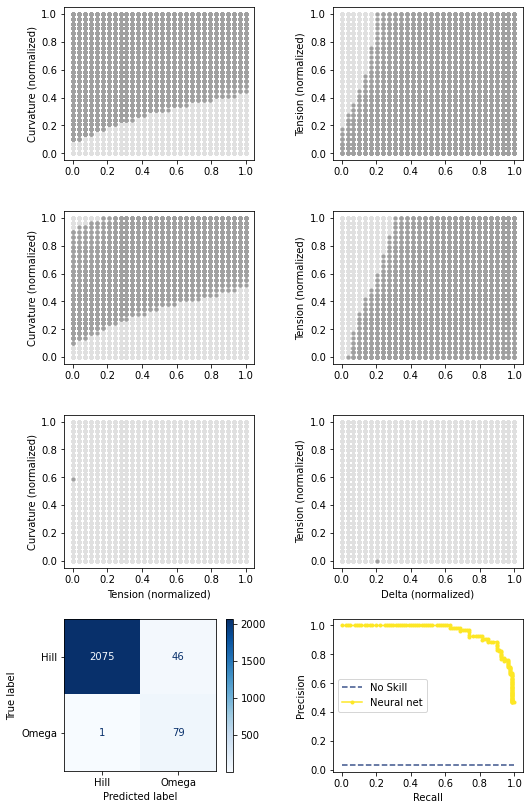

In [7]:
# Result 1: Bending rigidity; Neural net; VALIDATION

# Running on validation set
NN_predictions = NN.predict(x_validation)
rounded = [round(x[0]) for x in NN_predictions]

# Plotting

fig = plt.figure(figsize=(8.5, 11))
gs = GridSpec(nrows=5, ncols=2, width_ratios = [1,1])


rad_vals = [.15, .4, .7]
i = 0
rad_val = rad_vals[i]

ax7 = fig.add_subplot(gs[0, 0])
grid_params_sub = grid_params[['C0_norm', 'rad_norm','lam_norm', 'delta_norm']].where(grid_params.rad_norm == rad_val).dropna(how = 'all').reset_index(drop = 'True')
grid_pred = NN.predict(grid_params_sub.to_numpy())
grid_pred_rounded = [round(x[0]) for x in grid_pred]
results = grid_params_sub
results['preds'] = grid_pred_rounded

results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax7.scatter(results_notOmega.lam_norm, 1*results_notOmega.C0_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax7.scatter(results_omegas.lam_norm, 1*results_omegas.C0_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax7.set_xlabel('Tension (normalized)')
ax7.set_ylabel('Curvature (normalized)')
#ax7.title('Radius: ' + str(rad_val))

ax8 = fig.add_subplot(gs[0, 1])
results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax8.scatter(results_notOmega.delta_norm, results_notOmega.lam_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax8.scatter(results_omegas.delta_norm, results_omegas.lam_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax8.set_xlabel('Pressure (normalized)')
ax8.set_ylabel('Tension (normalized)')  
#ax8.title('Radius: ' + str(rad_val))

i = 1
rad_val = rad_vals[i]

ax9 = fig.add_subplot(gs[1, 0])
grid_params_sub = grid_params[['C0_norm', 'rad_norm','lam_norm', 'delta_norm']].where(grid_params.rad_norm == rad_val).dropna(how = 'all').reset_index(drop = 'True')
grid_pred = NN.predict(grid_params_sub.to_numpy())
grid_pred_rounded = [round(x[0]) for x in grid_pred]
results = grid_params_sub
results['preds'] = grid_pred_rounded

results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax9.scatter(results_notOmega.lam_norm, 1*results_notOmega.C0_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax9.scatter(results_omegas.lam_norm, 1*results_omegas.C0_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax9.set_xlabel('Tension (normalized)')
ax9.set_ylabel('Curvature (normalized)')
#ax9.title('Radius: ' + str(rad_val))

ax10 = fig.add_subplot(gs[1, 1])
results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax10.scatter(results_notOmega.delta_norm, results_notOmega.lam_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax10.scatter(results_omegas.delta_norm, results_omegas.lam_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax10.set_xlabel('Delta (normalized)')
ax10.set_ylabel('Tension (normalized)')  
#ax10.title('Radius: ' + str(rad_val))

i = 2
rad_val = rad_vals[i]

ax11 = fig.add_subplot(gs[2, 0])
grid_params_sub = grid_params[['C0_norm', 'rad_norm','lam_norm', 'delta_norm']].where(grid_params.rad_norm == rad_val).dropna(how = 'all').reset_index(drop = 'True')
grid_pred = NN.predict(grid_params_sub.to_numpy())
grid_pred_rounded = [round(x[0]) for x in grid_pred]
results = grid_params_sub
results['preds'] = grid_pred_rounded

results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax11.scatter(results_notOmega.lam_norm, 1*results_notOmega.C0_norm, c = '#E0E0E0', marker = '.', alpha = 1)
results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax11.scatter(results_omegas.lam_norm, 1*results_omegas.C0_norm, c = '#A0A0A0', marker = '.', alpha = 1)
ax11.set_xlabel('Tension (normalized)')
ax11.set_ylabel('Curvature (normalized)')
#ax11.title('Radius: ' + str(rad_val))

ax12 = fig.add_subplot(gs[2, 1])
results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax12.scatter(results_notOmega.delta_norm, results_notOmega.lam_norm, c = '#E0E0E0', marker = '.', alpha = 1)
results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax12.scatter(results_omegas.delta_norm, results_omegas.lam_norm, c = '#A0A0A0', marker = '.', alpha = 1)
ax12.set_xlabel('Delta (normalized)')
ax12.set_ylabel('Tension (normalized)')  


# Confusion matrices 

ax14 = fig.add_subplot(gs[3, 0])
cf_matrix = confusion_matrix(y_validation, rounded)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                              display_labels=['Hill', 'Omega'])
disp = disp.plot(cmap = 'Blues', ax = ax14)


ax16 = fig.add_subplot(gs[3, 1])
# PRC: Better for imbalanced classification like this problem

# Calculate precision-recall curve
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_validation, NN_predictions)
no_skill = len(pd.Series(y_validation[y_validation==1]).dropna(how = 'all')) / len(y_validation)
auc = sklearn.metrics.auc(recall, precision)
ax16.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', color = "#3b528b")
ax16.plot(recall, precision, marker='.', label='Neural net', color='#fde725')
ax16.set_xlabel('Recall')
ax16.set_ylabel('Precision')
#plt.title('Neural net PRC\n' +'AUC: ' + str(round(auc, 2)) + '; F1: ' + str(round(f1, 2)))
print('Neural net on validation set PRC\n' +'AUC: ' + str(round(auc, 2))) 

ax16.legend()


set_size(fig, (8.5 - 2, 11 - 2))
plt.tight_layout()
plt.savefig('Classification-NN-Delta-Validation.pdf', bbox_inches='tight')
plt.savefig('Classification-NN-Delta-Validation.png', bbox_inches='tight')
plt.show()

Neural net on test set PRC
AUC: 0.82


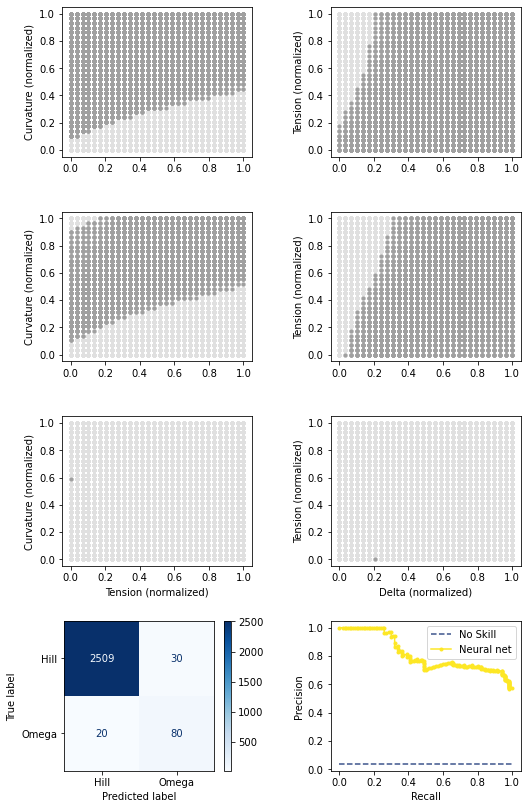

In [8]:
# Result 1: Bending rigidity; Neural net; TEST

# Running on test set
NN_predictions = NN.predict(x_test)
rounded = [round(x[0]) for x in NN_predictions]

# Plotting

fig = plt.figure(figsize=(8.5, 11))
gs = GridSpec(nrows=5, ncols=2, width_ratios = [1,1])


rad_vals = [.15, .4, .7]
i = 0
rad_val = rad_vals[i]

ax7 = fig.add_subplot(gs[0, 0])
grid_params_sub = grid_params[['C0_norm', 'rad_norm','lam_norm', 'delta_norm']].where(grid_params.rad_norm == rad_val).dropna(how = 'all').reset_index(drop = 'True')
grid_pred = NN.predict(grid_params_sub.to_numpy())
grid_pred_rounded = [round(x[0]) for x in grid_pred]
results = grid_params_sub
results['preds'] = grid_pred_rounded

results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax7.scatter(results_notOmega.lam_norm, 1*results_notOmega.C0_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax7.scatter(results_omegas.lam_norm, 1*results_omegas.C0_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax7.set_xlabel('Tension (normalized)')
ax7.set_ylabel('Curvature (normalized)')
#ax7.title('Radius: ' + str(rad_val))

ax8 = fig.add_subplot(gs[0, 1])
results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax8.scatter(results_notOmega.delta_norm, results_notOmega.lam_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax8.scatter(results_omegas.delta_norm, results_omegas.lam_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax8.set_xlabel('Pressure (normalized)')
ax8.set_ylabel('Tension (normalized)')  
#ax8.title('Radius: ' + str(rad_val))

i = 1
rad_val = rad_vals[i]

ax9 = fig.add_subplot(gs[1, 0])
grid_params_sub = grid_params[['C0_norm', 'rad_norm','lam_norm', 'delta_norm']].where(grid_params.rad_norm == rad_val).dropna(how = 'all').reset_index(drop = 'True')
grid_pred = NN.predict(grid_params_sub.to_numpy())
grid_pred_rounded = [round(x[0]) for x in grid_pred]
results = grid_params_sub
results['preds'] = grid_pred_rounded

results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax9.scatter(results_notOmega.lam_norm, 1*results_notOmega.C0_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax9.scatter(results_omegas.lam_norm, 1*results_omegas.C0_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax9.set_xlabel('Tension (normalized)')
ax9.set_ylabel('Curvature (normalized)')
#ax9.title('Radius: ' + str(rad_val))

ax10 = fig.add_subplot(gs[1, 1])
results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax10.scatter(results_notOmega.delta_norm, results_notOmega.lam_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax10.scatter(results_omegas.delta_norm, results_omegas.lam_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax10.set_xlabel('Delta (normalized)')
ax10.set_ylabel('Tension (normalized)')  
#ax10.title('Radius: ' + str(rad_val))

i = 2
rad_val = rad_vals[i]

ax11 = fig.add_subplot(gs[2, 0])
grid_params_sub = grid_params[['C0_norm', 'rad_norm','lam_norm', 'delta_norm']].where(grid_params.rad_norm == rad_val).dropna(how = 'all').reset_index(drop = 'True')
grid_pred = NN.predict(grid_params_sub.to_numpy())
grid_pred_rounded = [round(x[0]) for x in grid_pred]
results = grid_params_sub
results['preds'] = grid_pred_rounded

results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax11.scatter(results_notOmega.lam_norm, 1*results_notOmega.C0_norm, c = '#E0E0E0', marker = '.', alpha = 1)
results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax11.scatter(results_omegas.lam_norm, 1*results_omegas.C0_norm, c = '#A0A0A0', marker = '.', alpha = 1)
ax11.set_xlabel('Tension (normalized)')
ax11.set_ylabel('Curvature (normalized)')
#ax11.title('Radius: ' + str(rad_val))

ax12 = fig.add_subplot(gs[2, 1])
results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax12.scatter(results_notOmega.delta_norm, results_notOmega.lam_norm, c = '#E0E0E0', marker = '.', alpha = 1)
results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax12.scatter(results_omegas.delta_norm, results_omegas.lam_norm, c = '#A0A0A0', marker = '.', alpha = 1)
ax12.set_xlabel('Delta (normalized)')
ax12.set_ylabel('Tension (normalized)')  


# Confusion matrices 

ax14 = fig.add_subplot(gs[3, 0])
cf_matrix = confusion_matrix(y_test, rounded)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                              display_labels=['Hill', 'Omega'])
disp = disp.plot(cmap = 'Blues', ax = ax14)


ax16 = fig.add_subplot(gs[3, 1])
# PRC: Better for imbalanced classification like this problem

# Calculate precision-recall curve
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, NN_predictions)
no_skill = len(pd.Series(y_test[y_test==1]).dropna(how = 'all')) / len(y_test)
auc = sklearn.metrics.auc(recall, precision)
ax16.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', color = "#3b528b")
ax16.plot(recall, precision, marker='.', label='Neural net', color='#fde725')
ax16.set_xlabel('Recall')
ax16.set_ylabel('Precision')
#plt.title('Neural net PRC\n' +'AUC: ' + str(round(auc, 2)) + '; F1: ' + str(round(f1, 2)))
print('Neural net on test set PRC\n' +'AUC: ' + str(round(auc, 2))) 

ax16.legend()


set_size(fig, (8.5 - 2, 11 - 2))
plt.tight_layout()
plt.savefig('Classification-NN-Delta-Test.pdf', bbox_inches='tight')
plt.savefig('Classification-NN-Delta-Test.png', bbox_inches='tight')
plt.show()

xGBoost on validation set PRC
AUC: 0.49


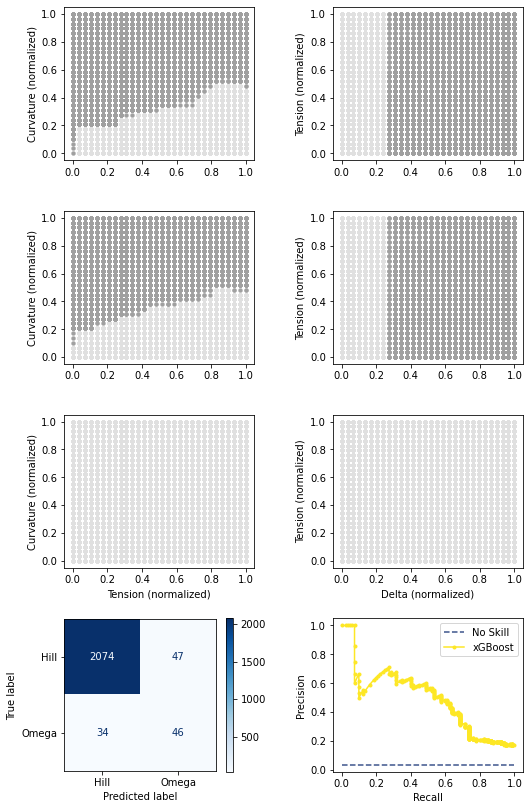

In [9]:
# Result 1: Delta; xGBoost; validation

# Run on validation set

y_pred = xg_reg.predict(x_validation)
RF_predictions = [round(value) for value in y_pred]
y_pred_prob = xg_reg.predict_proba(x_validation)[:,1]

# Plotting

fig = plt.figure(figsize=(8.5, 11))
gs = GridSpec(nrows=5, ncols=2, width_ratios = [1,1])


rad_vals = [.15, .4, .7]
i = 0
rad_val = rad_vals[i]

ax7 = fig.add_subplot(gs[0, 0])
grid_params_sub = grid_params[['C0_norm', 'rad_norm','lam_norm', 'delta_norm']].where(grid_params.rad_norm == rad_val).dropna(how = 'all').reset_index(drop = 'True')
grid_pred = xg_reg.predict(grid_params_sub.to_numpy())
#grid_pred_rounded = [round(x[0]) for x in grid_pred]
results = grid_params_sub
results['preds'] = grid_pred# grid_pred_rounded

results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax7.scatter(results_notOmega.lam_norm, 1*results_notOmega.C0_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax7.scatter(results_omegas.lam_norm, 1*results_omegas.C0_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax7.set_xlabel('Tension (normalized)')
ax7.set_ylabel('Curvature (normalized)')
#ax7.title('Radius: ' + str(rad_val))

ax8 = fig.add_subplot(gs[0, 1])
results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax8.scatter(results_notOmega.delta_norm, results_notOmega.lam_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax8.scatter(results_omegas.delta_norm, results_omegas.lam_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax8.set_xlabel('Delta (normalized)')
ax8.set_ylabel('Tension (normalized)')  
#ax8.title('Radius: ' + str(rad_val))

i = 1
rad_val = rad_vals[i]

ax9 = fig.add_subplot(gs[1, 0])
grid_params_sub = grid_params[['C0_norm', 'rad_norm','lam_norm', 'delta_norm']].where(grid_params.rad_norm == rad_val).dropna(how = 'all').reset_index(drop = 'True')
grid_pred = xg_reg.predict(grid_params_sub.to_numpy())
#grid_pred_rounded = [round(x[0]) for x in grid_pred]
results = grid_params_sub
results['preds'] = grid_pred # grid_pred_rounded

results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax9.scatter(results_notOmega.lam_norm, 1*results_notOmega.C0_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax9.scatter(results_omegas.lam_norm, 1*results_omegas.C0_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax9.set_xlabel('Tension (normalized)')
ax9.set_ylabel('Curvature (normalized)')
#ax9.title('Radius: ' + str(rad_val))

ax10 = fig.add_subplot(gs[1, 1])
results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax10.scatter(results_notOmega.delta_norm, results_notOmega.lam_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax10.scatter(results_omegas.delta_norm, results_omegas.lam_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax10.set_xlabel('Delta (normalized)')
ax10.set_ylabel('Tension (normalized)')  
#ax10.title('Radius: ' + str(rad_val))

i = 2
rad_val = rad_vals[i]

ax11 = fig.add_subplot(gs[2, 0])
grid_params_sub = grid_params[['C0_norm', 'rad_norm','lam_norm', 'delta_norm']].where(grid_params.rad_norm == rad_val).dropna(how = 'all').reset_index(drop = 'True')
grid_pred = xg_reg.predict(grid_params_sub.to_numpy())
# grid_pred_rounded = [round(x[0]) for x in grid_pred]
results = grid_params_sub
results['preds'] = grid_pred # grid_pred_rounded

results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax11.scatter(results_notOmega.lam_norm, 1*results_notOmega.C0_norm, c = '#E0E0E0', marker = '.', alpha = 1)
results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax11.scatter(results_omegas.lam_norm, 1*results_omegas.C0_norm, c = '#A0A0A0', marker = '.', alpha = 1)
ax11.set_xlabel('Tension (normalized)')
ax11.set_ylabel('Curvature (normalized)')
#ax11.title('Radius: ' + str(rad_val))

ax12 = fig.add_subplot(gs[2, 1])
results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax12.scatter(results_notOmega.delta_norm, results_notOmega.lam_norm, c = '#E0E0E0', marker = '.', alpha = 1)
results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax12.scatter(results_omegas.delta_norm, results_omegas.lam_norm, c = '#A0A0A0', marker = '.', alpha = 1)
ax12.set_xlabel('Delta (normalized)')
ax12.set_ylabel('Tension (normalized)')  
#ax12.title('Radius: ' + str(rad_val))


ax15 = fig.add_subplot(gs[3, 0])
plot_confusion_matrix(xg_reg,
                      x_validation, 
                      y_validation,
                      ax=ax15,
                      display_labels=['Hill', 'Omega'],
                      cmap='Blues')


# PRC: Better for imbalanced classification like this problem
# Calculate precision-recall curve
ax16 = fig.add_subplot(gs[3, 1])
#y_pred_prob = y_pred_prob = xg_reg.predict_proba(grid_params[['C0_norm', 'rad_norm','lam_norm', 'delta_norm']].to_numpy())[:,1]
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_validation, y_pred_prob)
no_skill = len(pd.Series(y_validation[y_validation==1]).dropna(how = 'all')) / len(y_validation)
auc = sklearn.metrics.auc(recall, precision)
ax16.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', color = "#3b528b")
ax16.plot(recall, precision, marker='.', label='xGBoost', color='#fde725')
ax16.set_xlabel('Recall')
ax16.set_ylabel('Precision')
#plt.title('Neural net PRC\n' +'AUC: ' + str(round(auc, 2)) + '; F1: ' + str(round(f1, 2)))
print('xGBoost on validation set PRC\n' +'AUC: ' + str(round(auc, 2))) 

ax16.legend()


set_size(fig, (8.5 - 2, 11 - 2))
plt.tight_layout()
plt.savefig('Classification-xGBoost-Delta-Validation.pdf', bbox_inches='tight')
plt.savefig('Classification-xGBoost-Delta-Validation.png', bbox_inches='tight')
plt.show()

xGBoost on test set PRC
AUC: 0.39


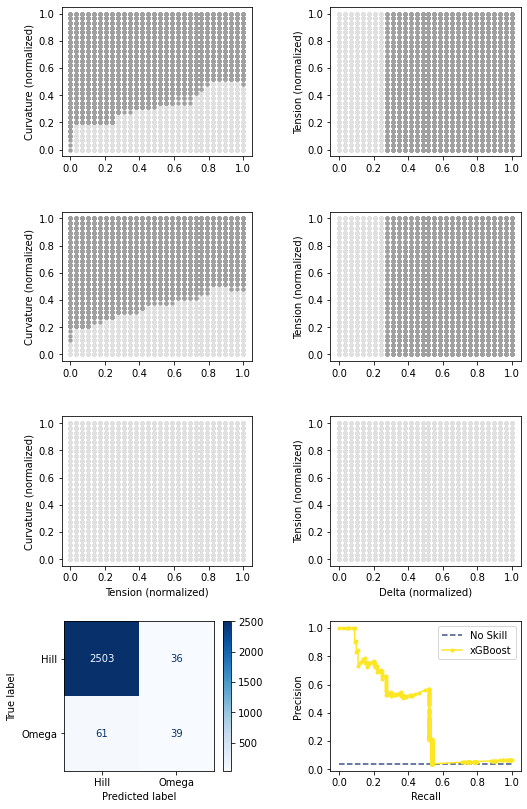

In [10]:
# Result 1: Delta; xGBoost; TEST

# Run on TEST set

y_pred = xg_reg.predict(x_test)
RF_predictions = [round(value) for value in y_pred]
y_pred_prob = xg_reg.predict_proba(x_test)[:,1]

# Plotting

fig = plt.figure(figsize=(8.5, 11))
gs = GridSpec(nrows=5, ncols=2, width_ratios = [1,1])


rad_vals = [.15, .4, .7]
i = 0
rad_val = rad_vals[i]

ax7 = fig.add_subplot(gs[0, 0])
grid_params_sub = grid_params[['C0_norm', 'rad_norm','lam_norm', 'delta_norm']].where(grid_params.rad_norm == rad_val).dropna(how = 'all').reset_index(drop = 'True')
grid_pred = xg_reg.predict(grid_params_sub.to_numpy())
#grid_pred_rounded = [round(x[0]) for x in grid_pred]
results = grid_params_sub
results['preds'] = grid_pred# grid_pred_rounded

results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax7.scatter(results_notOmega.lam_norm, 1*results_notOmega.C0_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax7.scatter(results_omegas.lam_norm, 1*results_omegas.C0_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax7.set_xlabel('Tension (normalized)')
ax7.set_ylabel('Curvature (normalized)')
#ax7.title('Radius: ' + str(rad_val))

ax8 = fig.add_subplot(gs[0, 1])
results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax8.scatter(results_notOmega.delta_norm, results_notOmega.lam_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax8.scatter(results_omegas.delta_norm, results_omegas.lam_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax8.set_xlabel('Delta (normalized)')
ax8.set_ylabel('Tension (normalized)')  
#ax8.title('Radius: ' + str(rad_val))

i = 1
rad_val = rad_vals[i]

ax9 = fig.add_subplot(gs[1, 0])
grid_params_sub = grid_params[['C0_norm', 'rad_norm','lam_norm', 'delta_norm']].where(grid_params.rad_norm == rad_val).dropna(how = 'all').reset_index(drop = 'True')
grid_pred = xg_reg.predict(grid_params_sub.to_numpy())
#grid_pred_rounded = [round(x[0]) for x in grid_pred]
results = grid_params_sub
results['preds'] = grid_pred # grid_pred_rounded

results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax9.scatter(results_notOmega.lam_norm, 1*results_notOmega.C0_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax9.scatter(results_omegas.lam_norm, 1*results_omegas.C0_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax9.set_xlabel('Tension (normalized)')
ax9.set_ylabel('Curvature (normalized)')
#ax9.title('Radius: ' + str(rad_val))

ax10 = fig.add_subplot(gs[1, 1])
results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax10.scatter(results_notOmega.delta_norm, results_notOmega.lam_norm, c = '#E0E0E0', marker = '.', alpha = 1)

results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax10.scatter(results_omegas.delta_norm, results_omegas.lam_norm, c = '#A0A0A0', marker = '.', alpha = 1)
#ax10.set_xlabel('Delta (normalized)')
ax10.set_ylabel('Tension (normalized)')  
#ax10.title('Radius: ' + str(rad_val))

i = 2
rad_val = rad_vals[i]

ax11 = fig.add_subplot(gs[2, 0])
grid_params_sub = grid_params[['C0_norm', 'rad_norm','lam_norm', 'delta_norm']].where(grid_params.rad_norm == rad_val).dropna(how = 'all').reset_index(drop = 'True')
grid_pred = xg_reg.predict(grid_params_sub.to_numpy())
# grid_pred_rounded = [round(x[0]) for x in grid_pred]
results = grid_params_sub
results['preds'] = grid_pred # grid_pred_rounded

results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax11.scatter(results_notOmega.lam_norm, 1*results_notOmega.C0_norm, c = '#E0E0E0', marker = '.', alpha = 1)
results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax11.scatter(results_omegas.lam_norm, 1*results_omegas.C0_norm, c = '#A0A0A0', marker = '.', alpha = 1)
ax11.set_xlabel('Tension (normalized)')
ax11.set_ylabel('Curvature (normalized)')
#ax11.title('Radius: ' + str(rad_val))

ax12 = fig.add_subplot(gs[2, 1])
results_notOmega = results.where(results.preds == 0).dropna(how = 'all')
Curv_ten_rad = ax12.scatter(results_notOmega.delta_norm, results_notOmega.lam_norm, c = '#E0E0E0', marker = '.', alpha = 1)
results_omegas = results.where(results.preds == 1).dropna(how = 'all')
ax12.scatter(results_omegas.delta_norm, results_omegas.lam_norm, c = '#A0A0A0', marker = '.', alpha = 1)
ax12.set_xlabel('Delta (normalized)')
ax12.set_ylabel('Tension (normalized)')  
#ax12.title('Radius: ' + str(rad_val))


ax15 = fig.add_subplot(gs[3, 0])
plot_confusion_matrix(xg_reg,
                      x_test, 
                      y_test,
                      ax=ax15,
                      display_labels=['Hill', 'Omega'],
                      cmap='Blues')


# PRC: Better for imbalanced classification like this problem
# Calculate precision-recall curve
ax16 = fig.add_subplot(gs[3, 1])
#y_pred_prob = y_pred_prob = xg_reg.predict_proba(grid_params[['C0_norm', 'rad_norm','lam_norm', 'delta_norm']].to_numpy())[:,1]
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, y_pred_prob)
no_skill = len(pd.Series(y_test[y_test==1]).dropna(how = 'all')) / len(y_test)
auc = sklearn.metrics.auc(recall, precision)
ax16.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill', color = "#3b528b")
ax16.plot(recall, precision, marker='.', label='xGBoost', color='#fde725')
ax16.set_xlabel('Recall')
ax16.set_ylabel('Precision')
#plt.title('Neural net PRC\n' +'AUC: ' + str(round(auc, 2)) + '; F1: ' + str(round(f1, 2)))
print('xGBoost on test set PRC\n' +'AUC: ' + str(round(auc, 2))) 

ax16.legend()


set_size(fig, (8.5 - 2, 11 - 2))
plt.tight_layout()
plt.savefig('Classification-xGBoost-Delta-Test.pdf', bbox_inches='tight')
plt.savefig('Classification-xGBoost-Delta-Test.png', bbox_inches='tight')
plt.show()